# Applying pulse forcing to a flow
Here, we will show how to apply a transient force to a flow.

In [1]:
using ViscousFlow

In [2]:
using Plots

For this case, we first seek to introduce a pulse to an otherwise quiescent fluid,
with no boundaries. The pulse shape will be a smooth Gaussian-distributed force, directed upward.

We will start with the usual steps: specify the problem parameters and the discretization.

In [3]:
my_params = Dict()

my_params["Re"] = 200
xlim = (-2.0,2.0)
ylim = (-2.0,4.0)
my_params["grid Re"] = 4.0
g = setup_grid(xlim,ylim,my_params)

PhysicalGrid{2}((210, 304), (105, 102), 0.02, ((-2.08, 2.08), (-2.02, 4.0200000000000005)), 10)

### Construct the forcing
There are a variety of forcing types available to us. Here, we will
use *area-type forcing*, which is distributed over a region of space.
We will create a short-lived force applied in the vertical direction in this region. For the
spatial distribution of this forcing, we make use of a Gaussian field. We will center it at (0,0), and
give it a strength of 10, using the `SpatialGaussian` constructor. The x component
of the force we set to zero, using the `EmptySpatialField` constructor.

In [4]:
σx = 0.5
σy = 0.1
x0 = y0 = 0.0
amp = 10
force_dist = [EmptySpatialField(),SpatialGaussian(σx,σy,x0,y0,amp)];

When we introduce forcing in any problem, it is essential to
supply a *model function* that supplies the instantaneous strength of the
forcing. This gives us the opportunity to specify the transient
aspect of the forcing. In this example, we modulate the force in time with a Gaussian,
with a small half-width in time equal to $\sigma_t = 0.1$, effectively creating a pulse.
We center it at time $t_0 = 0.1$ (using the `>>` shift operator). This is carried out in the function below,
in which we create the modulating function `modfcn`.
Note that `fr.generated_field()` provides the spatial distribution that
we specified with our spatial field `force_dist`. This is multiplied
by `modfcn`, our Gaussian pulse, evaluated at the current time.

In [5]:
function forcing_model!(σ,T,t,fr::AreaRegionCache,phys_params)
    σt = 0.1
    t0 = 0.1
    modfcn = Gaussian(σt,sqrt(π*σt^2)) >> t0
    σ .= modfcn(t)*fr.generated_field()
end

forcing_model! (generic function with 1 method)

We pack the model function and the spatial field together
into an `AreaForcingModel`, which we then put into a forcing dictionary.
It is important to use the key "forcing models" for this.

In [6]:
afm = AreaForcingModel(forcing_model!,spatialfield=force_dist)
forcing_dict = Dict("forcing models" => afm);

### Construct the system structure
We supply these forcing characteristics with the keyword argument `forcing` as we
set up the usual system structure:

In [7]:
sys = viscousflow_system(g,phys_params=my_params,forcing=forcing_dict);

The remaining steps go just as they did for the previous examples. We will simulate
the pulse for 4 time units:

In [8]:
u0 = init_sol(sys)
tspan = (0.0,10.0) # longer than we need, but just being safe
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 210, ny = 304) cell grid of type Float64 data
  Number of Dual nodes: (nx = 210, ny = 304), Float64[])

In [9]:
step!(integrator,4.0)

### Examine
Let's look at a sequence of snapshots of the forced flow. As we see, this
short-lived force creates a dipole-like pair of counter-rotating vortices that propagates upward under its
own influence.

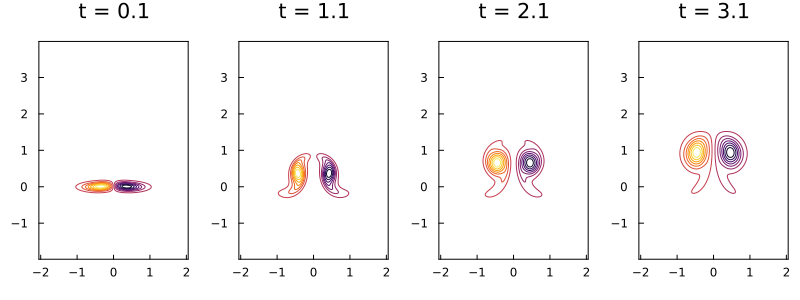

In [10]:
sol = integrator.sol
plt = plot(layout = (1,4), size = (800, 300), legend=:false)
tsnap = 0.1:1.0:3.1
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,title="t = $(round(t,digits=2))")
end
plt

And here is another look a the flow, this time with streamlines:

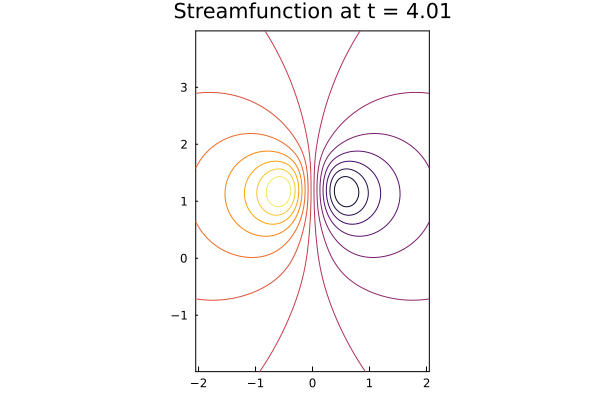

In [11]:
plot(streamfunction(integrator),sys,title="Streamfunction at t = $(round(integrator.t,digits=2))")

We can also supply more than one pulse. If we don't change the spatial
distribution, then we just redefine the model function and run it again:
Let's give 3 pulses, each separated by 1 time unit.

In [12]:
function forcing_model!(σ,T,t,fr::AreaRegionCache,phys_params)
    σt = 0.1
    t0 = [0.1, 1.1, 2.1]
    modfcn = (Gaussian(σt,sqrt(π*σt^2)) >> t0[1]) +
             (Gaussian(σt,sqrt(π*σt^2)) >> t0[2]) +
             (Gaussian(σt,sqrt(π*σt^2)) >> t0[3])
    σ .= modfcn(t)*fr.generated_field()
end

forcing_model! (generic function with 1 method)

In [13]:
u0 = init_sol(sys)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 210, ny = 304) cell grid of type Float64 data
  Number of Dual nodes: (nx = 210, ny = 304), Float64[])

In [14]:
step!(integrator,4.0)

### Examine
In this case, the pulses coalesce with one another

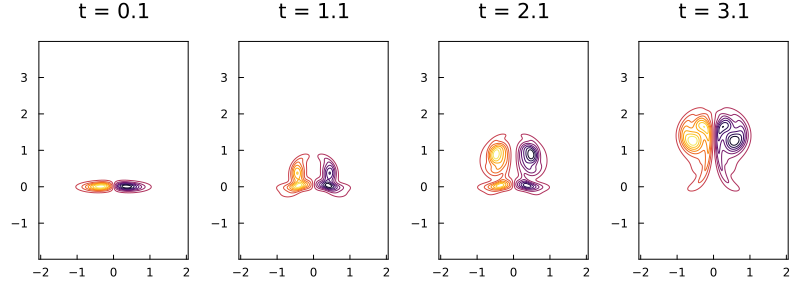

In [15]:
sol = integrator.sol
plt = plot(layout = (1,4), size = (800, 300), legend=:false)
tsnap = 0.1:1.0:3.1
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,title="t = $(round(t,digits=2))")
end
plt

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*